<a href="https://colab.research.google.com/github/leighd2008/TF-class-colab-notebooks/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU?
!nvidia-smi

Wed Jun 15 18:08:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-06-15 18:08:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 173.194.193.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2022-06-15 18:08:01 (165 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent

This is where we would visualize the data to become familiar with it. Since this is the same data we used in notebook 03, we are not going to repeat.

## Creating data loaders (preparig the data)

We'll use the `ImageDataGenerator` class to load in our images in batcher.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:") # Full training set, not 10%
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback


In [ ]:
# Create a TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

> 🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option. 

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on [https://tfhub.dev/]

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: [https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1]

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, 
      should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # changes (224, 224) to (224, 224, 3)

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Fit our resnet model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                        experiment_name="resnet50V2"
                                                        )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220615-180818
Epoch 1/5
24/24 [==============================] - 32s 763ms/step - loss: 1.8324 - accuracy: 0.3747 - val_loss: 1.1330 - val_accuracy: 0.6528
Epoch 2/5
24/24 [==============================] - 16s 690ms/step - loss: 0.8630 - accuracy: 0.7547 - val_loss: 0.8178 - val_accuracy: 0.7504
Epoch 3/5
24/24 [==============================] - 17s 731ms/step - loss: 0.6010 - accuracy: 0.8400 - val_loss: 0.7308 - val_accuracy: 0.7636
Epoch 4/5
24/24 [==============================] - 16s 684ms/step - loss: 0.4765 - accuracy: 0.8613 - val_loss: 0.7005 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 17s 717ms/step - loss: 0.3778 - accuracy: 0.9067 - val_loss: 0.6670 - val_accuracy: 0.7864


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time. AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import when you need it...
# import dependency
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss and accuracy curves for training and validation metrics

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

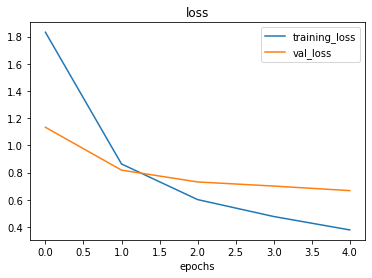

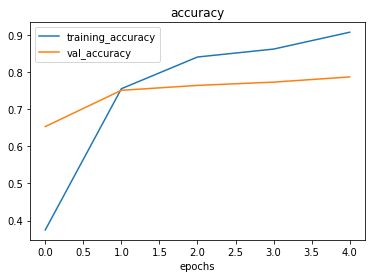

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create Efficientnet model
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile Efficientnet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [ ]:
from gc import callbacks
# Fit Efficientnet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                              experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220615-181007
Epoch 1/5
24/24 [==============================] - 26s 726ms/step - loss: 1.7873 - accuracy: 0.4520 - val_loss: 1.2606 - val_accuracy: 0.7468
Epoch 2/5
24/24 [==============================] - 15s 662ms/step - loss: 1.0187 - accuracy: 0.7893 - val_loss: 0.8413 - val_accuracy: 0.8256
Epoch 3/5
24/24 [==============================] - 16s 666ms/step - loss: 0.7277 - accuracy: 0.8453 - val_loss: 0.6839 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 15s 664ms/step - loss: 0.5870 - accuracy: 0.8787 - val_loss: 0.5988 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 15s 662ms/step - loss: 0.4971 - accuracy: 0.8920 - val_loss: 0.5472 - val_accuracy: 0.8644


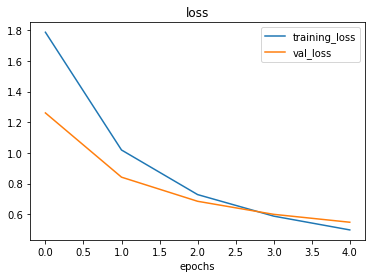

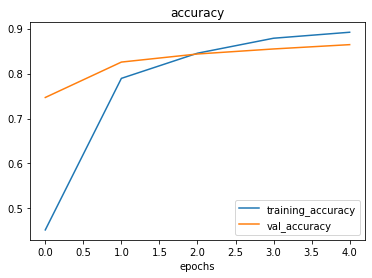

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model(e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models' results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to Tensorboard.dev.


In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet 50v2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/MH9djBeeQ5Sed727trRAIQ/

[2022-06-15T19:00:36] Started scanning logdir.
[2022-06-15T19:00:38] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.6 MB)
[2022-06-15T19:00:38] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/MH9djBeeQ5Sed727trRAIQ/


Our TensorBoard experiments are uploaded publically here:[https://tensorboard.dev/experiment/MH9djBeeQ5Sed727trRAIQ/ ]



In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/MH9djBeeQ5Sed727trRAIQ/
	Name                 EfficientNetB0 vs. ResNet 50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   MH9djBeeQ5Sed727trRAIQ
	Created              2022-06-15 19:00:36 (7 minutes ago)
	Updated              2022-06-15 19:00:38 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
https://tensorboard.dev/experiment/LuNdLt0BTQukaxm7fG2ehw/
	Name                 EfficientNetB0 vs. ResNet 50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   LuNdLt0BTQukaxm7fG2ehw
	Created              2022-06-15 18:56:43 (11 minutes ago)
	Updated              2022-06-15 18:56:45 (11 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tenso

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id LuNdLt0BTQukaxm7fG2ehw

Deleted experiment LuNdLt0BTQukaxm7fG2ehw.


In [ ]:
# Confirm deletion by re-checking what experiments you have left
!tensorboard dev list


https://tensorboard.dev/experiment/MH9djBeeQ5Sed727trRAIQ/
	Name                 EfficientNetB0 vs. ResNet 50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   MH9djBeeQ5Sed727trRAIQ
	Created              2022-06-15 19:00:36 (10 minutes ago)
	Updated              2022-06-15 19:00:38 (10 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
Total: 1 experiment(s)
